Caching is an invaluable tool for lowering the stress of repeated computes on your expensive functions, if you anticipate calling it with a relatively-narrow set of arguments. I read about it in the context of `model.predict()` calls, but wanted to lean on a more canonical example to show the how performance compares, caching vs non. The code is lifted and altered from the `functools.lru_cache()` [documentation](https://docs.python.org/3.3/library/functools.html#functools.lru_cache).

## By Example

Below, I've got two identical implementations for recursively serving up Fibonacci numbers-- the only difference being that one of them counts the number of times the function is called, and the other caches the results its seen for later use.

In [1]:
from functools import lru_cache

@lru_cache(maxsize=64)
def fib(n):
    if n < 2:
        return n
    else:
        return fib(n-1) + fib(n-2)

In [2]:
fib_call_count = 0

def fib_no_cache(n):
    global fib_call_count
    fib_call_count += 1
    
    if n < 2:
        return n
    else:
        return fib_no_cache(n-1) + fib_no_cache(n-2)

### Speed

Without caching, `fib(20)` runs on the order of milliseconds

In [3]:
%%timeit

fib_no_cache(20)

2.91 ms ± 51.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


With caching, it's measured instead in *nanoseconds*, which several orders of magnitude faster (10^-3) vs (10^-9)

In [4]:
%%timeit

fib(20)

56.5 ns ± 0.677 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


This alone is probably endorsement enough to use `@lru_cache()` where applicable.

### Call Efficiency

We can get a good understanding of the increase in efficiency by inspecting some of the utilities `functools` gives us.

On its own, a user-defined function doesn't come with anything attached to it, besides a host of `__dunder__` methods.

In [5]:
def blank_function():
    pass

[x for x in blank_function.__dir__() if x.find('__') == -1]

[]

On the other hand, we can see that functions implemented under the `@functools.lru_cache()` decorator, get attached with a couple functions to interface with the cache.

In [6]:
[x for x in fib.__dir__() if x.find('__') == -1]

['cache_info', 'cache_clear']

In practice, we can use this function to inspect how much work is going on under the hood.

At start, the `namedtuple` shows that:

* `hits=0`: The cache hasn't provided a shortcut yet
* `misses=0`: Nothing has been cached yet
* `maxsize=64`: The number of values that will be cached
* `currsize=0`: Similar to `misses`, this is how many values have been cached.

The key difference here is that `currsize` will only ever get as big as `maxsize`. At that point, it will drop the *oldest* cached call to `fib()`, as implied by the **L**ast **R**ecently **U**sed in `lru_cache()`.

In [7]:
fib.cache_clear()

print(fib.cache_info())

CacheInfo(hits=0, misses=0, maxsize=64, currsize=0)


Then, if we call our cached Fibonacci sequence, we can inspect how it's leveraging its cache.

In [8]:
for i in range(5):
    print(f"Fib({i}) =", fib(i))
    print(fib.cache_info(), '\n')

Fib(0) = 0
CacheInfo(hits=0, misses=1, maxsize=64, currsize=1) 

Fib(1) = 1
CacheInfo(hits=0, misses=2, maxsize=64, currsize=2) 

Fib(2) = 1
CacheInfo(hits=2, misses=3, maxsize=64, currsize=3) 

Fib(3) = 2
CacheInfo(hits=4, misses=4, maxsize=64, currsize=4) 

Fib(4) = 3
CacheInfo(hits=6, misses=5, maxsize=64, currsize=5) 



Pausing here to remark on what we're seeing.

The first `print` statement is self-explanitory, but look what's happening when we print out successive `fib.cache_info()`s:

* Every time we call `fib()` with a value not yet seen, `misses` gets incremented by 1.
* Because of the recursive nature of the algorithm, every time we get a new value for `n`, we get *two* new increments in `hits` (Look at the function defintion. `fib(4)` calls `fib(3)` and `fib(2)`. But because we *cached* these results, they're simply returned-- we don't then go on to perform *their* recursive calls.)

Moving on...

In [9]:
print(fib(6))
print(fib.cache_info())

8
CacheInfo(hits=9, misses=7, maxsize=64, currsize=7)


In [10]:
print(fib(7))
print(fib.cache_info())

13
CacheInfo(hits=11, misses=8, maxsize=64, currsize=8)


You get the idea.

### At Scale

Finally, I want to show what happens when we take multiple, successive values of `fib()`

In [11]:
%pylab inline

fib.cache_clear()

operations = []

for i in range(200):
    fib(i)
    hits, misses = fib.cache_info()[:2]
    operations.append((hits, misses, hits+misses))

operations = np.array(operations)

Populating the interactive namespace from numpy and matplotlib


In the cached case, the growth is steady and linear going from 0 to 200.

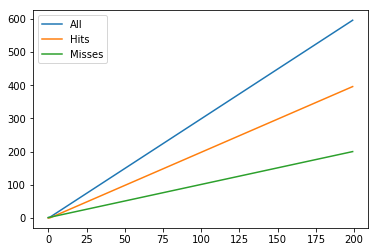

In [12]:
fig, ax = plt.subplots()

len_x = len(operations)
ax.plot(range(len_x), operations[:, 2], label='All')
ax.plot(range(len_x), operations[:, 0], label='Hits')
ax.plot(range(len_x), operations[:, 1], label='Misses')
ax.legend();

By the time we've called `fib(200)`, we've done 596 operations-- 200 new runs and 396 cache lookups.

In [13]:
operations[-1]

array([396, 200, 596])

Compare that to the non-cached case, **ran on 10% of the records**. World of difference.

In [14]:
fib_call_count = 0

fib_call_counts = []

for i in range(20):
    fib_no_cache(i)
    fib_call_counts.append(fib_call_count)
    
print(fib_call_count)

35400


Sixty times as many operations, on 10% of the top-level calls.

In [15]:
fib_call_count / operations[-1, -1]

59.395973154362416

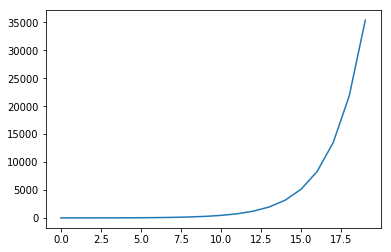

In [16]:
fig, ax = plt.subplots()

len_x = len(fib_call_counts)
ax.plot(range(len_x), fib_call_counts);

### In the wild

Now, suppose that we've got some application that randomly calls fib, per a uniform distribution between 1 and 10. And over the course of a day, it gets called 10 thousand times.

In [17]:
np.random.seed(0)
ten_k_calls = np.random.randint(1, 10, size=10000)

Then, comparing the relative operations between the cached and non-cached implementations, we have

In [18]:
fib_call_count = 0
fib.cache_clear()

cache = []
no_cache = []
for call in ten_k_calls:
    fib(call)
    fib_no_cache(call)
    
    hits, misses = fib.cache_info()[:2]
    cache.append(hits + misses)
    no_cache.append(fib_call_count)

Which leads to an enormous difference.

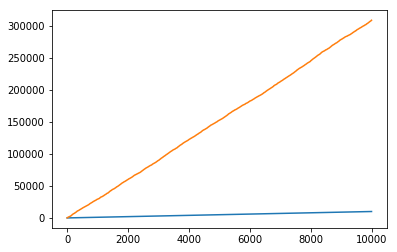

In [19]:
fig, ax = plt.subplots()

ax.plot(range(10000), cache)
ax.plot(range(10000), no_cache);

In [20]:
fib_call_count / 10000

30.8738

In [21]:
sum(fib.cache_info()[:2]) / 10000

1.0016

Now look what happens when we double the output range of our random number generator

In [22]:
np.random.seed(0)
ten_k_calls = np.random.randint(1, 21, size=10000)

Then, comparing the relative operations between the cached and non-cached implementations, we have

In [23]:
fib_call_count = 0
fib.cache_clear()

cache = []
no_cache = []
for call in ten_k_calls:
    fib(call)
    fib_no_cache(call)
    
    hits, misses = fib.cache_info()[:2]
    cache.append(hits + misses)
    no_cache.append(fib_call_count)

Which leads to an enormous difference.

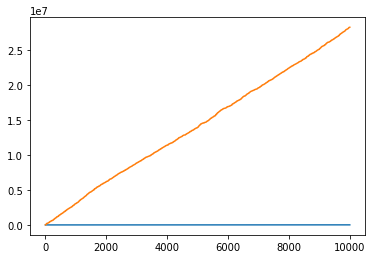

In [24]:
fig, ax = plt.subplots()

ax.plot(range(10000), cache)
ax.plot(range(10000), no_cache);

In [25]:
fib_call_count / 10000

2825.3216

In [26]:
sum(fib.cache_info()[:2]) / 10000

1.0038

This tangent is probably more a lesson in algorithm complexity than anything. Hopefully though, it's also a lesson in how that complexity can be mitigated by good use of `@functools.lru_cache()`